In [1]:
import autograd.numpy as np
import autograd
import matplotlib.pyplot as plt

# Newton's method 1D root finding example using autograd

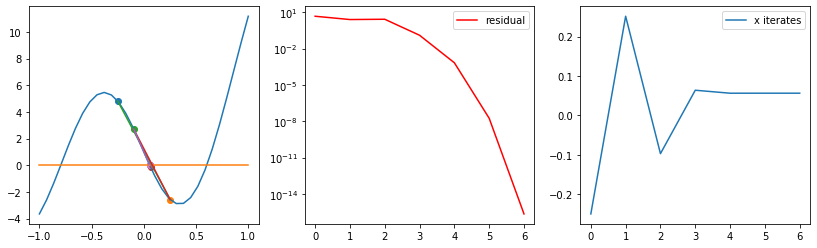

In [2]:
def f(x):
    return np.exp(2.0*x) - 5.0*np.sin(4.0*x)
df =  autograd.grad(f)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot([xp for xp in np.linspace(-1,1,30)],[f(xp) for xp in np.linspace(-1,1,30)])
plt.plot([xp for xp in np.linspace(-1,1,30)],[0 for xp in np.linspace(-1,1,30)])

# input parameters for Newton's method
x0 = -0.25
tol = 1e-12

# initialize
xn = x0
plt.scatter(x0, f(x0))
err = f(xn)
xiterates = [x0]
residuals = [err]

while err > tol:
    deltax = -np.power(df(xn),-1) * f(xn)
    plt.plot((xn,xn+deltax),(f(xn), f(xn+deltax)))
    plt.scatter(xn+deltax,f(xn+deltax))
    xn += deltax
    err = np.abs(f(xn))
    xiterates += [xn]
    residuals += [err]

iterations = range(len(residuals))
plt.subplot(1,3,2)
plt.semilogy(iterations,residuals,label='residual',color='red')
plt.legend()
plt.subplot(1,3,3)
plt.plot(iterations,xiterates,label='x iterates')
plt.legend()

# Coupled problem solved using Newton's method

In [3]:
# auxilliary lagrange interpolation function 
def lagrange_poly_explicit(x, xp, fp):
    """ given points (xp, fp), fit a lagrange polynomial and return
        the value at point x """
    f = 0.0
    # sum over points
    for m in range(len(xp)):
        # create the Lagrange basis polynomial for point m        
        l = 1.0
        for n in range(len(xp)):
            if n == m:
                continue
            if l == 1.0:
                l = (np.double(x) - np.double(xp[n]))/(np.double(xp[m]) - np.double(xp[n]))
            else:
                l *= (np.double(x) - np.double(xp[n]))/(np.double(xp[m]) - np.double(xp[n]))
        f += fp[m]*l
    return f

def lagrange_poly(p):
    xp = p[0:int(len(p)/2)]
    fp = p[int(len(p)/2):]
    return lambda x: lagrange_poly_explicit(x, xp, fp)

# auxilliary plotting function
def plot_f_over_x(function, domain, color='tab:blue',label=""):
    plt.plot(domain,[function(xp) for xp in domain], color=color, label=label)

### Fit the function f(x,y) defined on the domain $x \in [-1,1]$
Using a left interpolant $\texttt{hLeft(p,bc)}$ on $[-1,0]$ <br>
and a right interpolant $\texttt{hRight(p,bc)}$ on $[0,1]$.

### The interpolant hLeft (and hRight mutatis mutandis) must satisfy:
For each choice of bc at $x=0$, hLeft(p,bc) has a parameterization p so that as a function of x, <br>
and we would like $\texttt{hLeft(p,bc)(x)=f(x,bc/3)}$ for all $x \in (-1, 0]$ and $\texttt{hLeft(p,bc)(-1)=f(-1,3.5)}$ <br>
A residual minimization can obtain p for each choice of prescribed bc

### The coupling condition is 
$$\texttt{hLeft(0-) = hRight(0+)}$$

In [98]:
# the function to fit
def f(x,y):
    return 10*np.power(x,3)+np.power(x,2)*y + 3*y
bcLeft, bcRight = f(-1,3.5), f(1,3.5)

# left interpolant and residual (as function of couplingBC)
def hLeft(p,couplingBC):
    # params = [-1, -.75, -.25, 0, bcLeft, y1, y2, couplingBC] -> p = [y1, y2]
    return lagrange_poly([-1., -.75, -.25, 0.]+[bcLeft]+p+[couplingBC])
def hLeft_residual(p,couplingBC):
    # at x=0, 3*y = couplingBC
    y = couplingBC/3.
    return np.linalg.norm([(f(xp,y) - hLeft(p,couplingBC)(xp))/(50.-1.) for xp in np.linspace(-1,0,50)])

# right interpolant and residual (as function of couplingBC)
def hRight(p,couplingBC):
    # params = [0, .25, .75, 1, couplingBC, y1, y2, bcRight] -> p = [y1, y2]
    return lagrange_poly([0., .25, .75 ,1.]+[couplingBC]+p+[bcRight])
def hRight_residual(p,couplingBC):
    # at x=0, 3*y = couplingBC
    y = couplingBC/3.
    return np.linalg.norm([(f(xp,y) - hRight(p,couplingBC)(xp))/(50.-1.) for xp in np.linspace(0,1,50)])

def coupling_residual(leftp,rightp,bcLeft,bcRight):
    return np.power(hLeft(leftp,bcLeft)(0)-hRight(rightp,bcRight)(0),2)

# the exact solution is
soln = np.array([f(x,3.5) for x in [-.75, -.25, .25, .75]])
soln_left = [np.double(s) for s in soln[0:2]]
soln_right = [np.double(s) for s in soln[2:]]
print('soln is ',soln,f(0,3.5),f(0,3.5))

soln is  [ 8.25   10.5625 10.875  16.6875] 10.5 10.5


left residual: 18.23595404497072
right residual: 14.448375793288287
coupling residual: 100.0


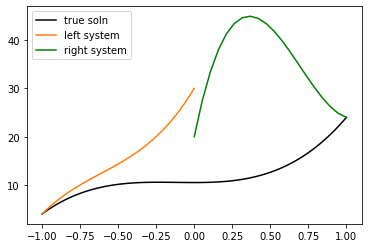

In [99]:
# example evaluation of a point [10,20],[43,32],30,20
plt.figure()
plot_f_over_x(lambda x:f(x,3.5), np.linspace(-1,1,100),color='black',label='true soln')
plot_f_over_x(hLeft([10,20],30), np.linspace(-1,0,20),color='tab:orange',label='left system')
plot_f_over_x(hRight([43,32],20), np.linspace(0,1,20),color='green',label='right system')
plt.legend()
print('left residual:',hLeft_residual([10,20],130))
print('right residual:',hRight_residual([43,32],120))
print('coupling residual:',coupling_residual([10,20],[53,42],30,20))

left residual: 1.02861569265068e-16
right residual: 2.9227442228975083e-16
coupling residual: 36.0


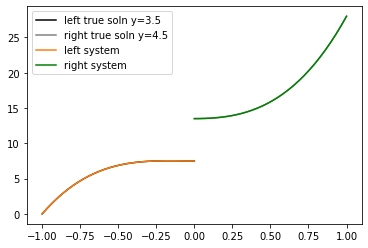

In [102]:
# check individual system solutions where the coupled residual is not satisfied
bcLeft_bogus, bcRight_bogus = f(-1,2.5), f(1,4.5)

# left interpolant and residual (as function of couplingBC)
def hLeft_bogus(p,couplingBC):
    # params = [-1, -.75, -.25, 0, bcLeft_bogus, y1, y2, couplingBC] -> p = [y1, y2]
    return lagrange_poly([-1., -.75, -.25, 0.]+[bcLeft_bogus]+p+[couplingBC])
def hLeft_bogus_residual(p,couplingBC):
    # at x=0, 3*y = couplingBC
    y = couplingBC/3.
    return np.linalg.norm([(f(xp,y) - hLeft(p,couplingBC)(xp))/(50.-1.) for xp in np.linspace(-1,0,50)])

# right interpolant and residual (as function of couplingBC)
def hRight_bogus(p,couplingBC):
    # params = [0, .25, .75, 1, couplingBC, y1, y2, bcRight_bogus] -> p = [y1, y2]
    return lagrange_poly([0., .25, .75 ,1.]+[couplingBC]+p+[bcRight_bogus])
def hRight_bogus_residual(p,couplingBC):
    # at x=0, 3*y = couplingBC
    y = couplingBC/3.
    return np.linalg.norm([(f(xp,y) - hRight(p,couplingBC)(xp))/(50.-1.) for xp in np.linspace(0,1,50)])

def coupling_bogus_residual(leftp,rightp,bcLeft,bcRight):
    return np.power(hLeft(leftp,bcLeft)(0)-hRight(rightp,bcRight)(0),2)

soln_bogus_left = [np.double(s) for s in np.array([f(x,2.5) for x in [-.75, -.25]])]
soln_bogus_right = [np.double(s) for s in np.array([f(x,4.5) for x in [.25, .75]])]

plt.figure()
plot_f_over_x(lambda x:f(x,2.5), np.linspace(-1,0,30),color='black',label='left true soln y=3.5')
plot_f_over_x(lambda x:f(x,4.5), np.linspace(0,1,30),color='grey',label='right true soln y=4.5')
plot_f_over_x(hLeft_bogus(soln_bogus_left,f(0,2.5)), np.linspace(-1,0,30),color='tab:orange',label='left system')
plot_f_over_x(hRight_bogus(soln_bogus_right,f(0,4.5)), np.linspace(0,1,30),color='green',label='right system')
plt.legend()
print('left residual:',hLeft_bogus_residual(soln_bogus_left,f(0,2.5)))
print('right residual:',hRight_bogus_residual(soln_bogus_right,f(0,4.5)))
print('coupling residual:',coupling_bogus_residual(soln_bogus_left,soln_bogus_right,f(0,2.5),f(0,4.5)))

left residual: 1.7003779825700145e-16
right residual: 3.2827745558232203e-16
coupling residual: 0.0


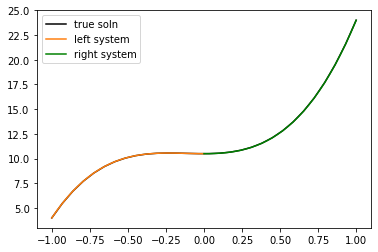

In [78]:
# check the exact solution's complete system residual

plt.figure()
plot_f_over_x(lambda x:f(x,3.5), np.linspace(-1,1,30),color='black',label='true soln')
plot_f_over_x(hLeft(soln_left,f(0,3.5)), np.linspace(-1,0,30),color='tab:orange',label='left system')
plot_f_over_x(hRight(soln_right,f(0,3.5)), np.linspace(0,1,30),color='green',label='right system')
plt.legend()
print('left residual:',hLeft_residual(soln_left,f(0,3.5)))
print('right residual:',hRight_residual(soln_right,f(0,3.5)))
print('coupling residual:',coupling_residual(soln_left,soln_right,f(0,3.5),f(0,3.5)))

In [8]:
# the full solution vector looks like [pLeft, pRight, bcLeft, bcRight]
# hLeft_residual is a function of [pLeft, bcLeft]
# hRight_residual is a function of [pRight, bcRight]
# coupling_residual is a function of [pLeft, pRight, bcLeft, bcRight]

# thus, the internal solution vector x is pLeft, pRight
# and the coupling parameter y is bcLeft, bcRight


# define the partial derivatives of the system
hLeft_p = autograd.grad(hLeft,0) # derivative with respect to params
hLeft_bc = autograd.grad(hLeft,1) # derivative with respect to coupling boundary condition
hRight_p = autograd.grad(hRight,0) # derivative with respect to params
hRight_bc = autograd.grad(hRight,1) # derivative with respect to coupling boundary condition
coupling_bcLeft = autograd.grad(coupling,0)
coupling_bcRight = autograd.grad(coupling,1)

NameError: name 'coupling' is not defined

In [ ]:
# toy coupling problem
# device model: drift-diffusion FEM
# circuit model: Kirchoff's current law
#
#          _________
#     .---|_device_|---.
#     |                | 
#   + |                |
#    Vsrc              |
#   - |                |
#     |_____/\/\/\_____|
#           circuit
#

In [ ]:
# set up the device problem

# 1D spatial mesh
device_length = 30
x = np.linspace(0,1,device_length)

# define basis functions on the mesh
def hat()


def device_residual(x,v_coupled):
    return drift diffusion in x
def device_bdy_current(x,v_coupled);
    return Jx - Jn

In [ ]:
def h(x,t):
    return np.dot(x,t) + np.sin(np.dot(x,t))
h_x = autograd.grad(h,0) # derivative with respect to x
h_t = autograd.grad(h,1) # derivative with respect to t


def circuit(v,v_coupled):
    return V = I*R
def circuit_bdy_current

    return 
def coupling(v_coupled):
    return charon_bdy_current(x,v) - xyce_bdy_current(x,v)

In [ ]:
x = np.linspace(0,2*np.pi,20)
plt.plot(x,[h(xp,1.0) for xp in x])
plt.plot(x,[h_t(xp,1.0) for xp in x])